In [1]:
from collections import defaultdict
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import imblearn
import sklearn.metrics as metrics
import xgboost

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, chi2, RFE, RFECV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix, f1_score, recall_score
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#Setting up graph standards
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Table of Contents

* [Data Loading](#data_load)
* [Upsampling](#up)
* [Scaling/Normalizing](#scale)
* [Feature Selection](#feat_selection)
    * [Method 1: SelectKBest](#selectkbest)
    * [Method 2: Feature ranking with recursive feature elimination and cross-validated selection of the best number of features](#rfecv)
    * [Method 3: Lasso](#Lasso)
    * [Method 4: Random Forest Feature Importance ](#rffi)
* [Handling Multicollinear Features]


## Data loading <a class="anchor" id="data_load"></a>

In [3]:
X = pd.DataFrame(load_breast_cancer().data)
X.columns = load_breast_cancer().feature_names
y = pd.DataFrame(load_breast_cancer().target)

In [4]:
#Splitting test/train 50/50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Train Data: (284, 30), (284, 1)
Test Data: (285, 30), (285, 1)


In [5]:
#Upsampling training data
counter = Counter(y_train)
upsample = SMOTE()
X_train, y_train = upsample.fit_resample(X_train, y_train)

print(f"Total Data after Upsampling: {len(X_train)}")
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

#Scaling train and test data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Total Data after Upsampling: 340
Train Data: (340, 30), (340, 1)
Test Data: (285, 30), (285, 1)
Train Data: (340, 30), (340, 1)
Test Data: (285, 30), (285, 1)


#### Baseline Model 

Accuracy on test data: 0.98
ROC AUC: 99.65076939866854%


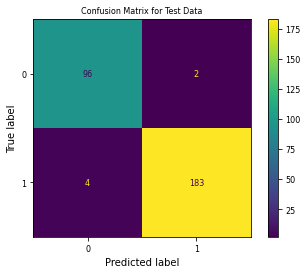

In [6]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))
fs_dict = {}

# Accuray On Test Data
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fs_dict.update({"Baseline_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test, y_test)}"]})

print(f"ROC AUC: {roc_auc*100}%")
plot_confusion_matrix(clf, X_test, y_test)
plt.title("Confusion Matrix for Test Data")
plt.show()

In order to make a simpler and more widely applicable model, I will endeavour to reduce the number of features needed for a good prediction.

## Feature Selection <a class="anchor" id="corr"></a>

* [Method 1: SelectKBest](#selectkbest)
* [Method 2: Feature ranking with recursive feature elimination and cross-validated selection of the best number of features](#rfecv)
* [Method 3: Lasso](#Lasso)
* [Method 4: Random Forest Feature Importance](#rffi)

### Method 1: SelectKBest <a class="anchor" id="selectkbest"></a>

[SelectKbest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

In [7]:
'''###Data to reset, if needed
X= pd.DataFrame(load_breast_cancer().data)
X.columns = load_breast_cancer().feature_names
y = pd.DataFrame(load_breast_cancer().target)

#Splitting test/train 50/50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

#Upsampling training data
counter = Counter(y_train)
upsample = SMOTE()
X_train, y_train = upsample.fit_resample(X_train, y_train)

#Scaling train and test data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)'''

'###Data to reset, if needed\nX= pd.DataFrame(load_breast_cancer().data)\nX.columns = load_breast_cancer().feature_names\ny = pd.DataFrame(load_breast_cancer().target)\n\n#Splitting test/train 50/50\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)\n\n#Upsampling training data\ncounter = Counter(y_train)\nupsample = SMOTE()\nX_train, y_train = upsample.fit_resample(X_train, y_train)\n\n#Scaling train and test data\nscaler = RobustScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)'

In [8]:
selector = SelectKBest(f_classif, k=15) #chi2 requires non negative
feature_set_skb = selector.fit_transform(X_train,y_train)

In [9]:
names = X.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
SelectKbest_df = pd.DataFrame(data = names_scores, columns=['Features', 'Scores'])
SelectKbest_df = SelectKbest_df.sort_values(by='Scores', ascending= False)

In [10]:
SelectKbest_df

,Features,Scores
14,worst concave points,602.547637
5,mean concave points,498.832996
10,worst perimeter,452.981632
9,worst radius,421.521191
1,mean perimeter,371.146554
0,mean radius,347.255857
4,mean concavity,322.764006
11,worst area,295.698845
13,worst concavity,290.342575
2,mean area,284.019393


In [11]:
feature_set_skb.shape

(340, 15)

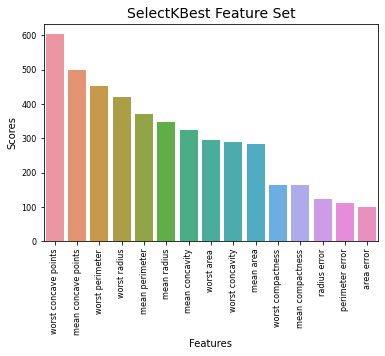

In [12]:
sns.barplot(x="Features", y="Scores",data=SelectKbest_df)
plt.xticks(rotation = 'vertical')
plt.title("SelectKBest Feature Set", fontsize=14)
  
plt.show()

In [13]:
X_test_skb = selector.transform(X_test)

print(f"Baseline Test Data: {X_test.shape}")
print(f"SelectKBest Test Data: {X_test_skb.shape}")

Baseline Test Data: (285, 30)
SelectKBest Test Data: (285, 15)


Accuracy on test data: 0.94
ROC AUC: 99.02324566190113%


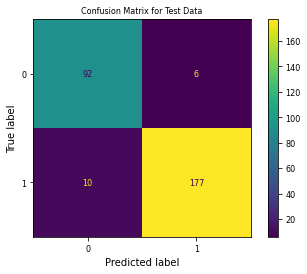

In [14]:
clf = LogisticRegression(random_state=42)
clf.fit(feature_set_skb, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test_skb, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_skb)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fs_dict.update({"SKB_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_skb, y_test)}"]})

print(f"ROC AUC: {roc_auc*100}%")
plot_confusion_matrix(clf, X_test_skb, y_test)
plt.title("Confusion Matrix for Test Data")
plt.show()

### Method 2: Feature ranking with recursive feature elimination and cross-validated selection of the best number of features <a class="anchor" id="rfecv"></a>

[RFE](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)
[RFECV](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

Before trying RFECV, I want to inspect RFE (2 models: Logistic Regression and Random Forest)

In [15]:
#RFE w/Logistic Regression Feature Selection
clf = LogisticRegression(random_state=42)
clf_selector = RFE(estimator=clf , n_features_to_select=15, step=1)
feature_set_rfe_log = clf_selector.fit_transform(X_train,y_train)

In [16]:
names = X.columns[clf_selector.get_support()]
scores = clf_selector.ranking_[clf_selector.get_support()]
names_scores = list(zip(names, scores))
rfe_clf_df = pd.DataFrame(data = names_scores, columns=['Features', 'Rank'])
rfe_clf_df.sort_values(by='Rank', ascending= False)

,Features,Rank
0,mean concavity,1
1,mean concave points,1
2,radius error,1
3,perimeter error,1
4,area error,1
5,concave points error,1
6,symmetry error,1
7,fractal dimension error,1
8,worst radius,1
9,worst texture,1


In [17]:
rf = RandomForestClassifier(random_state=42) 
rfe_selector = RFE(estimator=rf , n_features_to_select=15, step=1)
feature_set_rf = rfe_selector.fit_transform(X,y)

In [18]:
names = X.columns[rfe_selector.get_support()]
scores = rfe_selector.ranking_[rfe_selector.get_support()]
names_scores = list(zip(names, scores))
rfe_rf_df = pd.DataFrame(data = names_scores, columns=['Features', 'Rank'])
rfe_rf_df.sort_values(by='Rank', ascending= False)

,Features,Rank
0,mean radius,1
1,mean texture,1
2,mean perimeter,1
3,mean area,1
4,mean concavity,1
5,mean concave points,1
6,area error,1
7,worst radius,1
8,worst texture,1
9,worst perimeter,1


RFE doesn't seem to be a good fit for this data set. All features are ranked 1. Now I will try RFECV.

In [19]:
clf = LogisticRegression(random_state=42)
rfecv_clf_selector = RFECV(estimator=clf ,step=1, cv=5)
rfecv_clf_feature_set = rfecv_clf_selector.fit_transform(X_train,y_train)

In [20]:
names = X.columns[rfecv_clf_selector.get_support()]
scores = rfecv_clf_selector.ranking_[rfecv_clf_selector.get_support()]
names_scores = list(zip(names, scores))
rfecv_clf = pd.DataFrame(data = names_scores, columns=['Features', 'Rank'])
rfecv_clf.sort_values(by='Rank', ascending= False)

,Features,Rank
0,mean concavity,1
1,mean concave points,1
2,radius error,1
3,perimeter error,1
4,area error,1
5,concave points error,1
6,symmetry error,1
7,fractal dimension error,1
8,worst radius,1
9,worst texture,1


In [21]:
rfecv_clf.shape

(14, 2)

In [22]:
print('Optimal number of features: {}'.format(rfecv_clf_selector.n_features_))

Optimal number of features: 14


In [23]:
rf = RandomForestClassifier()  
rfecv_selector = RFECV(estimator=rf ,step=1, cv=5)
rfecv_feature_set = rfecv_selector.fit_transform(X_train,y_train)

In [24]:
names = X.columns[rfecv_selector.get_support()]
scores = rfecv_selector.ranking_[rfecv_selector.get_support()]
names_scores = list(zip(names, scores))
rfecv_df = pd.DataFrame(data = names_scores, columns=['Features', 'Rank'])
rfecv_df.sort_values(by='Rank', ascending= False)

,Features,Rank
0,mean radius,1
15,concavity error,1
27,worst symmetry,1
26,worst concave points,1
25,worst concavity,1
24,worst compactness,1
23,worst smoothness,1
22,worst area,1
21,worst perimeter,1
20,worst texture,1


In [25]:
rfecv_df.shape

(29, 2)

In [26]:
print('Optimal number of features: {}'.format(rfecv_selector.n_features_))

Optimal number of features: 29


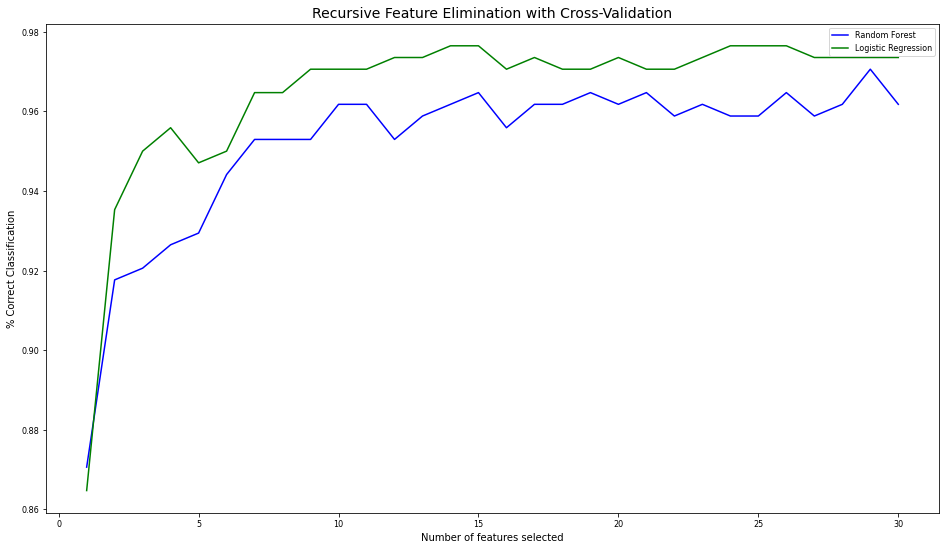

In [27]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation',fontsize=14)
plt.xlabel('Number of features selected')
plt.ylabel('% Correct Classification')
plt.plot(range(1, len(rfecv_selector.grid_scores_) + 1), rfecv_selector.grid_scores_, color='blue', label='Random Forest')
plt.plot(range(1, len(rfecv_clf_selector.grid_scores_) + 1), rfecv_clf_selector.grid_scores_, color='green', label='Logistic Regression')
plt.legend()

plt.show()

Of the two models, the Logistic Regression did best. I will test it out.

In [28]:
X_test_rfecv = rfecv_clf_selector.transform(X_test)

print(f"Baseline Test Data: {X_test.shape}")
print(f"SelectKBest Test Data: {X_test_rfecv.shape}")

Baseline Test Data: (285, 30)
SelectKBest Test Data: (285, 14)


Accuracy on test data: 0.96
ROC AUC: 99.60711557350213%


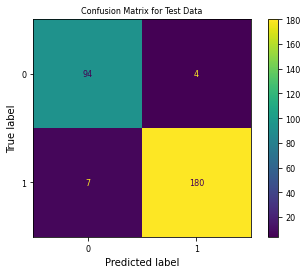

In [29]:
clf = LogisticRegression(random_state=42)
clf.fit(rfecv_clf_feature_set, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test_rfecv, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_rfecv)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fs_dict.update({"RFECV_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_rfecv, y_test)}"]})

print(f"ROC AUC: {roc_auc*100}%")
plot_confusion_matrix(clf,X_test_rfecv, y_test)
plt.title("Confusion Matrix for Test Data")
plt.show()

### Method 3: Lasso <a class="anchor" id="Lasso"></a>

In [30]:
# SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
estimator = LassoCV(cv=5)
sfm = SelectFromModel(estimator)
sfm_feature_set = sfm.fit_transform(X_train, y_train)

In [31]:
feature_mask = sfm.get_support()
feature_name = X.columns[feature_mask]
feature_name

Index(['mean radius', 'mean texture', 'mean area', 'mean smoothness',
       'mean compactness', 'mean concave points', 'mean symmetry',
       'mean fractal dimension', 'radius error', 'texture error', 'area error',
       'smoothness error', 'concavity error', 'concave points error',
       'symmetry error', 'fractal dimension error', 'worst radius',
       'worst texture', 'worst area', 'worst smoothness', 'worst compactness',
       'worst concavity', 'worst symmetry'],
      dtype='object')

In [32]:
feature_name.shape

(23,)

In [33]:
X_test_lasso = sfm.transform(X_test)

print(f"Baseline Test Data: {X_test.shape}")
print(f"Lasso Test Data: {X_test_lasso.shape}")

Baseline Test Data: (285, 30)
Lasso Test Data: (285, 23)


Accuracy on test data: 0.97
ROC AUC: 99.66168285496016%


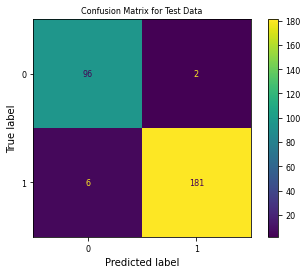

In [34]:
clf = LogisticRegression(random_state=42)
clf.fit(sfm_feature_set, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test_lasso, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_lasso)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fs_dict.update({"LassoCV_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_lasso, y_test)}"]})

print(f"ROC AUC: {roc_auc*100}%")
plot_confusion_matrix(clf,X_test_lasso, y_test)
plt.title("Confusion Matrix for Test Data")
plt.show()

### Method 4: Random Forest Feature Importance <a class="anchor" id="rffi"></a>

In [35]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [36]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(rf.score(X_test, y_test)))

Accuracy on test data: 0.96


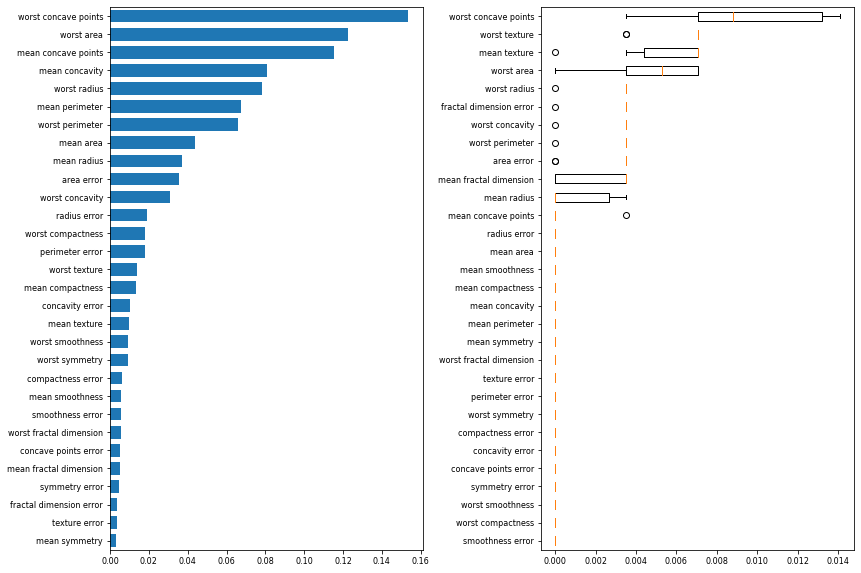

In [37]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

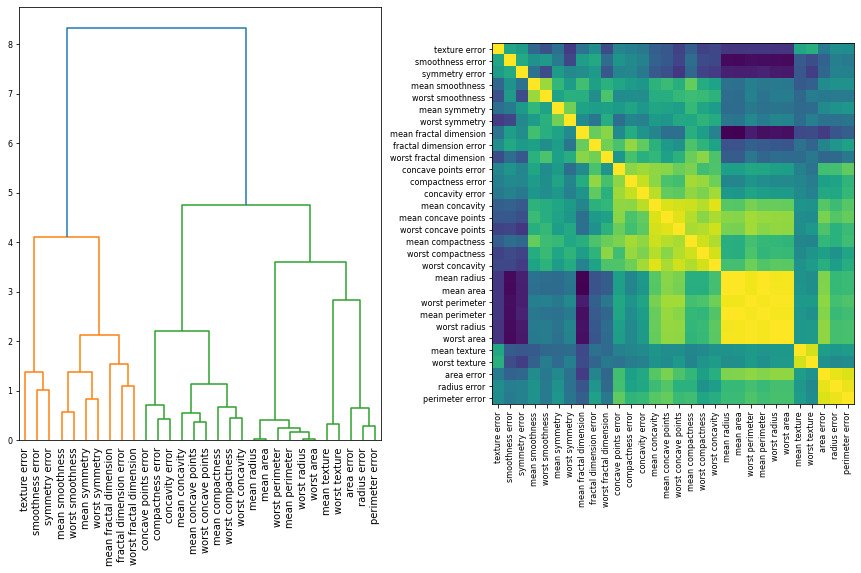

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [41]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_rfi = X_train[:, selected_features]
X_test_rfi = X_test[:, selected_features]


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rfi, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      rf.score(X_test_rfi, y_test)))

Accuracy on test data with features removed: 0.94


Accuracy on test data: 0.91
ROC AUC: 97.12976099530722%


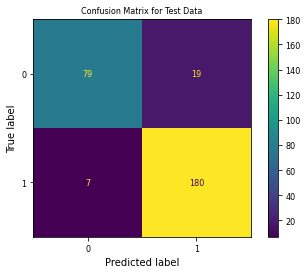

In [42]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_rfi, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test_rfi, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_rfi)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fs_dict.update({"RF_Feat_Importance_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_rfi, y_test)}"]})

print(f"ROC AUC: {roc_auc*100}%")
plot_confusion_matrix(clf,X_test_rfi, y_test)
plt.title("Confusion Matrix for Test Data")
plt.show()

In [43]:
data.feature_names[selected_features]

array(['mean radius', 'mean texture', 'mean smoothness',
       'mean compactness', 'mean concavity', 'mean symmetry',
       'mean fractal dimension', 'radius error', 'texture error',
       'smoothness error', 'compactness error', 'symmetry error',
       'fractal dimension error', 'worst fractal dimension'], dtype='<U23')

In [44]:
feat_sel_df = pd.DataFrame(fs_dict)

In [45]:
feat_sel_df = feat_sel_df.T

In [46]:
feat_sel_df.columns =['ROC AUC', 'Accuracy']

In [47]:
feat_sel_df

,ROC AUC,Accuracy
Baseline_LogReg,ROC AUC: 99.65076939866854%,Accuracy:0.9789473684210527
SKB_LogReg,ROC AUC: 99.02324566190113%,Accuracy:0.9438596491228071
RFECV_LogReg,ROC AUC: 99.60711557350213%,Accuracy:0.9614035087719298
LassoCV_LogReg,ROC AUC: 99.66168285496016%,Accuracy:0.9719298245614035
RF_Feat_Importance_LogReg,ROC AUC: 97.12976099530722%,Accuracy:0.9087719298245615


In [48]:
feat_sel_df['ROC AUC'].str.replace('ROC AUC:', '')
feat_sel_df['ROC AUC'].str.replace('%', '')

Baseline_LogReg              ROC AUC: 99.65076939866854
SKB_LogReg                   ROC AUC: 99.02324566190113
RFECV_LogReg                 ROC AUC: 99.60711557350213
LassoCV_LogReg               ROC AUC: 99.66168285496016
RF_Feat_Importance_LogReg    ROC AUC: 97.12976099530722
Name: ROC AUC, dtype: object

In [49]:
feat_sel_df.Accuracy.str.replace('Accuracy:', '')

Baseline_LogReg              0.9789473684210527
SKB_LogReg                   0.9438596491228071
RFECV_LogReg                 0.9614035087719298
LassoCV_LogReg               0.9719298245614035
RF_Feat_Importance_LogReg    0.9087719298245615
Name: Accuracy, dtype: object

In [50]:
features= pd.DataFrame(load_breast_cancer().feature_names)

In [51]:
combo_df = features.merge(SelectKbest_df.Features,how='left', left_on=0, right_on="Features")
combo_df

,0,Features
0,mean radius,mean radius
1,mean texture,NaN
2,mean perimeter,mean perimeter
3,mean area,mean area
4,mean smoothness,NaN
5,mean compactness,mean compactness
6,mean concavity,mean concavity
7,mean concave points,mean concave points
8,mean symmetry,NaN
9,mean fractal dimension,NaN


In [52]:
combo_df = combo_df.merge(rfecv_clf.Features,how='left', left_on=0, right_on="Features")
combo_df

,0,Features_x,Features_y
0,mean radius,mean radius,NaN
1,mean texture,NaN,NaN
2,mean perimeter,mean perimeter,NaN
3,mean area,mean area,NaN
4,mean smoothness,NaN,NaN
5,mean compactness,mean compactness,NaN
6,mean concavity,mean concavity,mean concavity
7,mean concave points,mean concave points,mean concave points
8,mean symmetry,NaN,NaN
9,mean fractal dimension,NaN,NaN


In [53]:
Lasso_df = pd.DataFrame(feature_name, columns=["Lasso"])

In [54]:
combo_df = combo_df.merge(Lasso_df,how='left', left_on=0, right_on='Lasso')
combo_df

,0,Features_x,Features_y,Lasso
0,mean radius,mean radius,NaN,mean radius
1,mean texture,NaN,NaN,mean texture
2,mean perimeter,mean perimeter,NaN,NaN
3,mean area,mean area,NaN,mean area
4,mean smoothness,NaN,NaN,mean smoothness
5,mean compactness,mean compactness,NaN,mean compactness
6,mean concavity,mean concavity,mean concavity,NaN
7,mean concave points,mean concave points,mean concave points,mean concave points
8,mean symmetry,NaN,NaN,mean symmetry
9,mean fractal dimension,NaN,NaN,mean fractal dimension


In [55]:
rfi_df = pd.DataFrame(data.feature_names[selected_features], columns=['selected_features'])

In [56]:
combo_df = combo_df.merge(rfi_df,how='left', left_on=0, right_on='selected_features')
combo_df

,0,Features_x,Features_y,Lasso,selected_features
0,mean radius,mean radius,NaN,mean radius,mean radius
1,mean texture,NaN,NaN,mean texture,mean texture
2,mean perimeter,mean perimeter,NaN,NaN,NaN
3,mean area,mean area,NaN,mean area,NaN
4,mean smoothness,NaN,NaN,mean smoothness,mean smoothness
5,mean compactness,mean compactness,NaN,mean compactness,mean compactness
6,mean concavity,mean concavity,mean concavity,NaN,mean concavity
7,mean concave points,mean concave points,mean concave points,mean concave points,NaN
8,mean symmetry,NaN,NaN,mean symmetry,mean symmetry
9,mean fractal dimension,NaN,NaN,mean fractal dimension,mean fractal dimension


In [57]:
combo_df.columns = ['Baseline', 'SelectKbest','RFECV', 'Lasso','RF Feat Importance'] 

In [58]:
combo_df

,Baseline,SelectKbest,RFECV,Lasso,RF Feat Importance
0,mean radius,mean radius,NaN,mean radius,mean radius
1,mean texture,NaN,NaN,mean texture,mean texture
2,mean perimeter,mean perimeter,NaN,NaN,NaN
3,mean area,mean area,NaN,mean area,NaN
4,mean smoothness,NaN,NaN,mean smoothness,mean smoothness
5,mean compactness,mean compactness,NaN,mean compactness,mean compactness
6,mean concavity,mean concavity,mean concavity,NaN,mean concavity
7,mean concave points,mean concave points,mean concave points,mean concave points,NaN
8,mean symmetry,NaN,NaN,mean symmetry,mean symmetry
9,mean fractal dimension,NaN,NaN,mean fractal dimension,mean fractal dimension
